In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import cv2

In [2]:
# Extracting the compressed dataset.
from zipfile import ZipFile 
data_path = 'archive.zip' 
with ZipFile(data_path, 'r') as zip: 
    zip.extractall()

In [3]:
# path to the folder containing our dataset

dataset = 'traffic_Data/DATA'

# path of label file
labelfile = pd.read_csv('labels.csv')

In [4]:
labelfile.head()

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)


In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset, validation_split=0.2, subset='training',
                                                              image_size=(224,224), seed=123, batch_size=32)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset, validation_split=0.2, subset='validation',
                                                              image_size=(224,224), seed=123, batch_size=32)

Found 4170 files belonging to 58 classes.
Using 3336 files for training.
Found 4170 files belonging to 58 classes.
Using 834 files for validation.


In [6]:
class_number = train_ds.class_names
class_names = []
for i in class_number:
    class_names.append(labelfile['Name'][int(i)])

In [7]:
class_names

['Speed limit (5km/h)',
 'Speed limit (15km/h)',
 'Dont Go straight',
 'Dont Go Left',
 'Dont Go Left or Right',
 'Dont Go Right',
 'Dont overtake from Left',
 'No Uturn',
 'No Car',
 'No horn',
 'Speed limit (40km/h)',
 'Speed limit (50km/h)',
 'Speed limit (30km/h)',
 'Go straight or right',
 'Go straight',
 'Go Left',
 'Go Left or right',
 'Go Right',
 'keep Left',
 'keep Right',
 'Roundabout mandatory',
 'watch out for cars',
 'Horn',
 'Speed limit (40km/h)',
 'Bicycles crossing',
 'Uturn',
 'Road Divider',
 'Traffic signals',
 'Danger Ahead',
 'Zebra Crossing',
 'Bicycles crossing',
 'Children crossing',
 'Dangerous curve to the left',
 'Dangerous curve to the right',
 'Speed limit (50km/h)',
 'Unknown1',
 'Unknown2',
 'Unknown3',
 'Go right or straight',
 'Go left or straight',
 'Unknown4',
 'ZigZag Curve',
 'Train Crossing',
 'Under Construction',
 'Unknown5',
 'Speed limit (60km/h)',
 'Fences',
 'Heavy Vehicle Accidents',
 'Unknown6',
 'Give Way',
 'No stopping',
 'No entry',
 

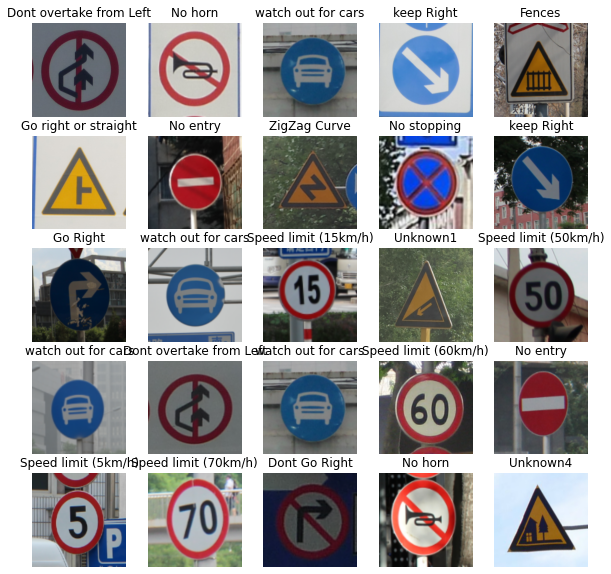

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()


In [9]:
data_aug = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(224,224,3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical')
])

In [10]:
model = Sequential()
model.add(data_aug)
model.add(tf.keras.layers.Rescaling(1./255))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(labelfile), activation='softmax'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

In [12]:
from keras.utils import plot_model
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mycallback = [EarlyStopping(monitor='val_loss', patience=5)]
history = model.fit(train_ds, validation_data='val_ds',callbacks=mycallback, epochs=5)

Epoch 1/5
 66/105 [=================>............] - ETA: 10:03 - loss: 3.5444 - accuracy: 0.1288